In [1]:
import numpy as np
from lifelines import KaplanMeierFitter, CoxPHFitter
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import os
import glob
from pathlib import Path
import seaborn as sns

kaplan_plots = True
cox_analysis = False

date_time_str = '20230622_002127'
data_path = Path(os.getcwd())

if kaplan_plots:
    kmf = KaplanMeierFitter()

    csv_files = glob.glob(os.path.join(data_path, f"outputs/{date_time_str}/*.csv"))

    if not os.path.exists(f"imgs/{date_time_str}"):
        os.makedirs(f"imgs/{date_time_str}")

    # Group runs by experiment
    grouped_files = {}
    for file in csv_files:
        file_name = os.path.basename(file)
        name_without_suffix = file_name.rsplit("-", 1)[0]
        suffix = file_name.rsplit("-", 1)[1]
        group_key = name_without_suffix

        if group_key not in grouped_files:
            grouped_files[group_key] = []

        grouped_files[group_key].append(file)


    kmfs = {}
    cphs = {}

    # Print the grouped file paths
    for group_key, files in grouped_files.items():
        fig = plt.figure()
        # For computing the mean
        surv_func_ci = pd.DataFrame()
        amt_of_runs = len(files)
        
        mean_survival_plots = pd.DataFrame(columns=list("TE"))
        CPH_data = pd.DataFrame()

        for i, file_path in enumerate(files):
            data_for_CPH = pd.read_csv(file_path)
            
            data_for_CPH_copy = data_for_CPH.copy()
            data_for_CPH_copy.loc[data_for_CPH_copy['T'] == 1000, 'E'] = 0 # post hoc fix if the last timestep is used as time of death
            
            datakf = data_for_CPH_copy[list('TE')]
            
            mean_survival_plots = pd.concat([mean_survival_plots, datakf])
            CPH_data = pd.concat([CPH_data, data_for_CPH_copy])

        kmf = KaplanMeierFitter(label=group_key)
        cphs[group_key] = CPH_data

        kmfs[group_key] = kmf.fit(mean_survival_plots["T"], mean_survival_plots['E']) # Deze line geeft die warnings, maar kon het niet oplossen nog
        kmf.plot(label='Mean')

        plt.suptitle("Kaplan-Meier survival graph", fontsize=18)
        plt.title(group_key, fontsize=10)
        plt.xlabel("Time steps")
        plt.ylabel("Survival probability")
        plt.legend()

        plt.savefig(f"imgs/{date_time_str}/km-{group_key}.png")
        plt.close()

c:\Users\freek\AppData\Local\Programs\Python\Python310\lib\site-packages\lifelines\utils\__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
c:\Users\freek\AppData\Local\Programs\Python\Python310\lib\site-packages\lifelines\utils\__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
c:\Users\freek\AppData\Local\Programs\Python\Python310\lib\site-packages\lifelines\utils\__init__.py:1187: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.

In [10]:
# All combinations image A (for Appendix)
fig = plt.figure(figsize=(10, 10))

legend_ax = fig.add_subplot(111, frameon=False)
legend_ax.axis('off')

nr_agents = [50, 100] # [50, 100, 200, 300]
dists = ['Sides', 'Uniform', 'RandomGrid']
probs = [0.5, 0.8, 1]
i=0

for nr_agent in nr_agents:
    for dist in dists:
        for prob in probs:
            i+=1

            if i == 1:
                ax = plt.subplot(6, 3, i)
            else:
                ax = plt.subplot(6, 3, i, sharex=ax, sharey=ax)

            if dist == 'RandomGrid':
                dist_name = 'Random Blobs'
            else:
                dist_name = dist
            plt.title(f'{dist_name}, nr_agents = {nr_agent}, prob. = {prob}', fontsize=10)
            ax = kmfs[f'Baseline-no_trade-{dist}-{nr_agent}-{prob}'].plot(label='Non-trading', legend=None, linewidth=1)
            ax.xaxis.set_label_text('')
            ax = kmfs[f'Baseline-random-{dist}-{nr_agent}-{prob}'].plot(label='Random-trading', legend=None, linewidth=1)
            ax.xaxis.set_label_text('')
            ax = kmfs[f'Baseline-pathfind_neighbor-{dist}-{nr_agent}-{prob}'].plot(label='Neighbor-trading', legend=None, linewidth=1)
            ax.xaxis.set_label_text('')
            ax = kmfs[f'Market-pathfind_market-{dist}-{nr_agent}-{prob}'].plot(label='Market-trading', legend=None, linewidth=1)
            ax.xaxis.set_label_text('')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(handles), bbox_to_anchor=(0.5, 0.94), fontsize=12)
fig.tight_layout(rect=(0.03, 0.03, 1, 0.9))
plt.subplots_adjust(wspace=0.3)
fig.text(0.5, 0.03, 'Time steps', ha='center', va='center', fontsize=14)
fig.text(0.03,  0.5, 'Survival probability', ha='center', va='center', rotation='vertical', fontsize=14)
plt.suptitle("Kaplan-Meier survival graphs (A)", fontsize=20, y=0.98)
plt.savefig(f"imgs/{date_time_str}/kms-comparison-market-uber-A.pdf")
plt.close()


# All combinations image B (for Appendix)
fig = plt.figure(figsize=(10, 10))

legend_ax = fig.add_subplot(111, frameon=False)
legend_ax.axis('off')

nr_agents = [200, 300] # [50, 100, 200, 300]
dists = ['Sides', 'Uniform', 'RandomGrid']
probs = [0.5, 0.8, 1]
i=0

for nr_agent in nr_agents:
    for dist in dists:
        for prob in probs:
            i+=1

            if i == 1:
                ax = plt.subplot(6, 3, i)
            else:
                ax = plt.subplot(6, 3, i, sharex=ax, sharey=ax)
            
            if dist == 'RandomGrid':
                dist_name = 'Random Blobs'
            else:
                dist_name = dist
            plt.title(f'{dist_name}, nr_agents = {nr_agent}, prob. = {prob}', fontsize=10)
            ax = kmfs[f'Baseline-no_trade-{dist}-{nr_agent}-{prob}'].plot(label='Non-trading', legend=None, linewidth=1)
            ax.xaxis.set_label_text('')
            ax = kmfs[f'Baseline-random-{dist}-{nr_agent}-{prob}'].plot(label='Random-trading', legend=None, linewidth=1)
            ax.xaxis.set_label_text('')
            ax = kmfs[f'Baseline-pathfind_neighbor-{dist}-{nr_agent}-{prob}'].plot(label='Neighbor-trading', legend=None, linewidth=1)
            ax.xaxis.set_label_text('')
            ax = kmfs[f'Market-pathfind_market-{dist}-{nr_agent}-{prob}'].plot(label='Market-trading', legend=None, linewidth=1)
            ax.xaxis.set_label_text('')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(handles), bbox_to_anchor=(0.5, 0.94), fontsize=12)
fig.tight_layout(rect=(0.03, 0.03, 1, 0.9))
plt.subplots_adjust(wspace=0.3)
fig.text(0.5, 0.03, 'Time steps', ha='center', va='center', fontsize=14)
fig.text(0.03,  0.5, 'Survival probability', ha='center', va='center', rotation='vertical', fontsize=14)
plt.suptitle("Kaplan-Meier survival graphs (B)", fontsize=20, y=0.98)
plt.savefig(f"imgs/{date_time_str}/kms-comparison-market-uber-B.pdf")
plt.close()

C:\Users\guido\AppData\Local\Temp\ipykernel_19832\220188696.py:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(6, 3, i)
C:\Users\guido\AppData\Local\Temp\ipykernel_19832\220188696.py:64: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(6, 3, i)


# CPH for BLobs

Index(['T', 'E', 'Scenario', 'Agent_type', 'Distribution', 'Num_agents',
       'Trading', 'Move_prob', 'Run_number'],
      dtype='object')
        T    E  Trade_random  Trade_search  Trade_market
0     0.0  0.0             0             0             0
1     0.0  0.0             0             0             0
2     0.0  0.0             0             0             0
3     0.0  0.0             0             0             0
4   292.0  1.0             0             0             0
..    ...  ...           ...           ...           ...
45  189.0  1.0             0             0             1
46  149.0  1.0             0             0             1
47  575.0  1.0             0             0             1
48    0.0  0.0             0             0             1
49  280.0  1.0             0             0             1

[1000 rows x 5 columns]


<lifelines.CoxPHFitter: fitted with 1000 total observations, 620 right-censored observations>
             duration col = 'T'
                event col = 'E'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1000
number of events observed = 380
   partial log-likelihood = -1873.97
         time fit was run = 2023-06-22 00:08:05 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
Trade_random   0.05       1.05       0.14            -0.23             0.33                 0.80                 1.39
Trade_search  -0.19       0.83       0.16            -0.50             0.12                 0.61                 1.12
Trade_market  -0.36       0.70       0.10            -0.56            -0.16                 0.57                 0.86

               cmp to     z      p   -log2(p)
covariate                                    
Trade_random     0.00  0.35   0.73       0.46
Trade_search     0.00 -1.23   0.22       2.18
Trade_market     0.00 -3.48 <0.005      10.96
---
Concordance = 0.50
Partial AIC = 3753.93
log-likelihood ratio test = 14.38 on 3 df
-log2(p) of ll-ratio test = 8.68

Summary dataframe:
                  coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                     
Trade_random  0.049578   1.050827  0.141599       -0.227951        0.327106   
Trade_search -0.192310   0.825051  0.156968       -0.499962        0.115342   
Trade_market -0.358381   0.698807  0.103014       -0.560285       -0.156476   

              exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                                  
Trade_random             0.796164             1.386949     0.0  0.350129   
Trade_search             0.606554             1.122257     0.0 -1.225153   
Trade_market             0.571046             0.855152     0.0 -3.478942   

                     p   -log2(p)  
covariate                          
Trade_random  0.726242   0.461478  
Trade_search  0.220517   2.181036  
Trade_market  0.000503  10.956014  


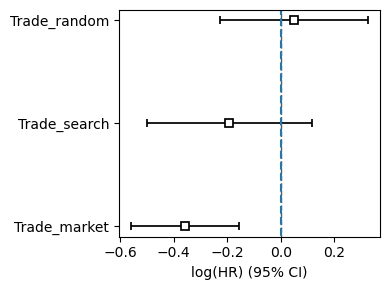

In [11]:
cox_analysis = True

if cox_analysis:
    combined_df = pd.concat([cphs['Baseline-no_trade-RandomGrid-50-0.8'],
                             cphs['Baseline-random-RandomGrid-50-0.8'],
                             cphs['Baseline-pathfind_neighbor-RandomGrid-50-0.8'],
                             cphs['Market-pathfind_market-RandomGrid-50-0.8'],
    ])

    
    le = LabelEncoder()
    print(combined_df.keys())

    def update_trades(row):
        if row["Agent_type"] == 'no_trade':
            row["Trade_random"] = 0
            row["Trade_search"] = 0
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'random':
            row["Trade_random"] = 1
            row["Trade_search"] = 0
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'pathfind_neighbor':
            row["Trade_random"] = 0
            row["Trade_search"] = 1
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'pathfind_market':
            row["Trade_random"] = 0
            row["Trade_search"] = 0
            row["Trade_market"] = 1
        return row

    # Assuming you have a DataFrame named combined_df
    combined_df = combined_df.apply(update_trades, axis=1)
    
    combined_df["Scenario"] = le.fit_transform(combined_df["Scenario"])
    combined_df["Trading"] = le.fit_transform(combined_df["Trading"])
    combined_df["Distribution"] = le.fit_transform(combined_df["Distribution"])
    combined_df = combined_df.drop(["Run_number", 'Num_agents', 'Distribution', 'Move_prob', 'Trading', 'Agent_type', 'Scenario'], axis=1)

    print( combined_df)
    combined_df.to_csv(f"outputs/{date_time_str}_CPH-trading-RG-50-0.8-data.csv")

    cph = CoxPHFitter(penalizer=0.1)
    cph.fit(combined_df, "T", "E", show_progress=False)
    cph.check_assumptions(combined_df.reset_index(drop=True), p_value_threshold=0.05, show_plots=True)

    cph.print_summary()
    print("Summary dataframe:")
    cph_df = cph.summary
    print(cph_df)
    cph_df.to_csv(f"outputs/{date_time_str}_CPH-trading-RG-50-0.8-results.csv")

    plt.figure(figsize=(4, 3))
    cph.plot()
    plt.vlines(x=0, ymin=-1, ymax=6, color='#1f77b4', linestyles='--')
    plt.tight_layout()
    plt.show()

# CPH for Sides

Index(['T', 'E', 'Scenario', 'Agent_type', 'Distribution', 'Num_agents',
       'Trading', 'Move_prob', 'Run_number'],
      dtype='object')
        T    E  Trade_random  Trade_search  Trade_market
0   170.0  1.0             0             0             0
1   120.0  1.0             0             0             0
2   158.0  1.0             0             0             0
3   194.0  1.0             0             0             0
4   130.0  1.0             0             0             0
..    ...  ...           ...           ...           ...
45  178.0  1.0             0             0             1
46  170.0  1.0             0             0             1
47  205.0  1.0             0             0             1
48  279.0  1.0             0             0             1
49  242.0  1.0             0             0             1

[1000 rows x 5 columns]


<lifelines.CoxPHFitter: fitted with 1000 total observations, 4 right-censored observations>
             duration col = 'T'
                event col = 'E'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1000
number of events observed = 996
   partial log-likelihood = -5832.00
         time fit was run = 2023-06-22 00:08:06 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
Trade_random  -0.27       0.76       0.08            -0.44            -0.11                 0.65                 0.90
Trade_search  -0.79       0.45       0.09            -0.96            -0.62                 0.38                 0.54
Trade_market  -0.67       0.51       0.08            -0.84            -0.51                 0.43                 0.60

               cmp to     z      p   -log2(p)
covariate                                    
Trade_random     0.00 -3.21 <0.005       9.56
Trade_search     0.00 -9.20 <0.005      64.55
Trade_market     0.00 -7.95 <0.005      48.88
---
Concordance = 0.50
Partial AIC = 11670.01
log-likelihood ratio test = 105.00 on 3 df
-log2(p) of ll-ratio test = 72.70

Summary dataframe:
                  coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                     
Trade_random -0.270223   0.763209  0.084158       -0.435171       -0.105276   
Trade_search -0.791020   0.453382  0.086013       -0.959602       -0.622438   
Trade_market -0.671898   0.510738  0.084563       -0.837638       -0.506158   

              exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                                  
Trade_random             0.647154             0.900076     0.0 -3.210886   
Trade_search             0.383045             0.536635     0.0 -9.196539   
Trade_market             0.432731             0.602807     0.0 -7.945539   

                         p   -log2(p)  
covariate                              
Trade_random  1.323265e-03   9.561683  
Trade_search  3.696632e-20  64.552350  
Trade_market  1.933479e-15  48.877722  


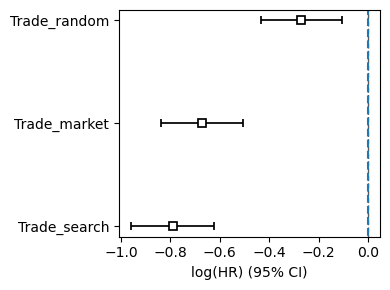

In [12]:
cox_analysis = True

if cox_analysis:
    combined_df = pd.concat([cphs[f'Baseline-no_trade-Sides-50-1'],
                             cphs[f'Baseline-random-Sides-50-1'],
                             cphs[f'Baseline-pathfind_neighbor-Sides-50-1'],
                             cphs[f'Market-pathfind_market-Sides-50-1'],
    ])

    
    le = LabelEncoder()
    print(combined_df.keys())

    def update_trades(row):
        if row["Agent_type"] == 'no_trade':
            row["Trade_random"] = 0
            row["Trade_search"] = 0
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'random':
            row["Trade_random"] = 1
            row["Trade_search"] = 0
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'pathfind_neighbor':
            row["Trade_random"] = 0
            row["Trade_search"] = 1
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'pathfind_market':
            row["Trade_random"] = 0
            row["Trade_search"] = 0
            row["Trade_market"] = 1
        return row

    # Assuming you have a DataFrame named combined_df
    combined_df = combined_df.apply(update_trades, axis=1)
    
    combined_df["Scenario"] = le.fit_transform(combined_df["Scenario"])
    combined_df["Trading"] = le.fit_transform(combined_df["Trading"])
    combined_df["Distribution"] = le.fit_transform(combined_df["Distribution"])
    combined_df = combined_df.drop(["Run_number", 'Num_agents', 'Distribution', 'Move_prob', 'Trading', 'Agent_type', 'Scenario'], axis=1)

    print( combined_df)
    combined_df.to_csv(f"outputs/{date_time_str}_CPH-trading-Sides-data.csv")

    cph = CoxPHFitter(penalizer=0.1)
    cph.fit(combined_df, "T", "E", show_progress=False)
    cph.check_assumptions(combined_df.reset_index(drop=True), p_value_threshold=0.05, show_plots=True)

    cph.print_summary()
    print("Summary dataframe:")
    cph_df = cph.summary
    print(cph_df)
    cph_df.to_csv(f"outputs/{date_time_str}_CPH-trading-Sides-results.csv")

    plt.figure(figsize=(4, 3))
    cph.plot()
    plt.vlines(x=0, ymin=-1, ymax=6, color='#1f77b4', linestyles='--')
    plt.tight_layout()
    plt.show()

# CPH Sides threshold of significance market (varying nr agents)

Index(['T', 'E', 'Scenario', 'Agent_type', 'Distribution', 'Num_agents',
       'Trading', 'Move_prob', 'Run_number'],
      dtype='object')


<lifelines.CoxPHFitter: fitted with 1000 total observations, 0 right-censored observations>
             duration col = 'T'
                event col = 'E'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1000
number of events observed = 1000
   partial log-likelihood = -5856.14
         time fit was run = 2023-06-22 00:08:07 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
Trade_random   0.12       1.13       0.08            -0.04             0.28                 0.96                 1.32
Trade_search  -0.66       0.52       0.08            -0.83            -0.49                 0.44                 0.61
Trade_market  -0.56       0.57       0.08            -0.72            -0.39                 0.49                 0.68

               cmp to     z      p   -log2(p)
covariate                                    
Trade_random     0.00  1.42   0.16       2.69
Trade_search     0.00 -7.76 <0.005      46.76
Trade_market     0.00 -6.62 <0.005      34.73
---
Concordance = 0.50
Partial AIC = 11718.27
log-likelihood ratio test = 111.98 on 3 df
-log2(p) of ll-ratio test = 77.69

Index(['T', 'E', 'Scenario', 'Agent_type', 'Distribution', 'Num_agents',
       'Trading', 'Move_prob', 'Run_number'],
      dtype='object')


<lifelines.CoxPHFitter: fitted with 2000 total observations, 0 right-censored observations>
             duration col = 'T'
                event col = 'E'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 2000
number of events observed = 2000
   partial log-likelihood = -13115.35
         time fit was run = 2023-06-22 00:08:09 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
Trade_random  -0.11       0.90       0.06            -0.22             0.01                 0.80                 1.01
Trade_search  -0.62       0.54       0.06            -0.74            -0.50                 0.48                 0.61
Trade_market  -0.65       0.52       0.06            -0.77            -0.54                 0.46                 0.58

               cmp to      z      p   -log2(p)
covariate                                     
Trade_random     0.00  -1.87   0.06       4.02
Trade_search     0.00 -10.23 <0.005      79.17
Trade_market     0.00 -11.02 <0.005      91.38
---
Concordance = 0.50
Partial AIC = 26236.69
log-likelihood ratio test = 182.36 on 3 df
-log2(p) of ll-ratio test = 128.11

Index(['T', 'E', 'Scenario', 'Agent_type', 'Distribution', 'Num_agents',
       'Trading', 'Move_prob', 'Run_number'],
      dtype='object')


<lifelines.CoxPHFitter: fitted with 4000 total observations, 3 right-censored observations>
             duration col = 'T'
                event col = 'E'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 4000
number of events observed = 3997
   partial log-likelihood = -28985.57
         time fit was run = 2023-06-22 00:08:13 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
Trade_random  -0.19       0.83       0.04            -0.27            -0.11                 0.76                 0.90
Trade_search  -0.49       0.61       0.04            -0.57            -0.41                 0.56                 0.67
Trade_market  -0.73       0.48       0.04            -0.81            -0.65                 0.44                 0.52

               cmp to      z      p   -log2(p)
covariate                                     
Trade_random     0.00  -4.55 <0.005      17.50
Trade_search     0.00 -11.63 <0.005     101.52
Trade_market     0.00 -17.29 <0.005     220.04
---
Concordance = 0.50
Partial AIC = 57977.14
log-likelihood ratio test = 341.63 on 3 df
-log2(p) of ll-ratio test = 242.55

Index(['T', 'E', 'Scenario', 'Agent_type', 'Distribution', 'Num_agents',
       'Trading', 'Move_prob', 'Run_number'],
      dtype='object')


<lifelines.CoxPHFitter: fitted with 6000 total observations, 0 right-censored observations>
             duration col = 'T'
                event col = 'E'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 6000
number of events observed = 6000
   partial log-likelihood = -45935.31
         time fit was run = 2023-06-22 00:08:18 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
Trade_random  -0.19       0.82       0.03            -0.26            -0.13                 0.77                 0.88
Trade_search  -0.38       0.69       0.03            -0.44            -0.31                 0.64                 0.73
Trade_market  -0.77       0.47       0.03            -0.83            -0.70                 0.43                 0.50

               cmp to      z      p   -log2(p)
covariate                                     
Trade_random     0.00  -5.78 <0.005      26.98
Trade_search     0.00 -11.06 <0.005      92.06
Trade_market     0.00 -22.12 <0.005     357.85
---
Concordance = 0.50
Partial AIC = 91876.62
log-likelihood ratio test = 534.10 on 3 df
-log2(p) of ll-ratio test = 381.06

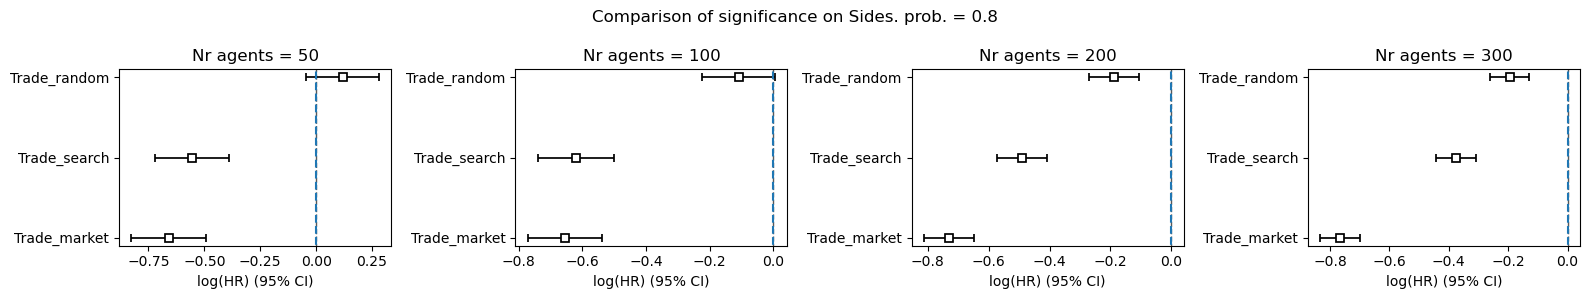

In [13]:
cox_analysis = True

nagentsss = [50, 100, 200, 300]

plt.figure(figsize=(16,3))

for i, n_agents in enumerate(nagentsss):
    if i > 0:
        ax = plt.subplot(1, 4, i+1, sharey=ax)
    else:
        ax = plt.subplot(1, 4, i+1)
    combined_df = pd.concat([cphs[f'Baseline-no_trade-Sides-{n_agents}-0.8'],
                             cphs[f'Baseline-random-Sides-{n_agents}-0.8'],
                             cphs[f'Baseline-pathfind_neighbor-Sides-{n_agents}-0.8'],
                             cphs[f'Market-pathfind_market-Sides-{n_agents}-0.8'],
    ])
    
    le = LabelEncoder()
    print(combined_df.keys())

    def update_trades(row):
        if row["Agent_type"] == 'no_trade':
            row["Trade_random"] = 0
            row["Trade_search"] = 0
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'random':
            row["Trade_random"] = 1
            row["Trade_search"] = 0
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'pathfind_neighbor':
            row["Trade_random"] = 0
            row["Trade_search"] = 1
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'pathfind_market':
            row["Trade_random"] = 0
            row["Trade_search"] = 0
            row["Trade_market"] = 1
        return row

    # Assuming you have a DataFrame named combined_df
    combined_df = combined_df.apply(update_trades, axis=1)
    
    combined_df["Scenario"] = le.fit_transform(combined_df["Scenario"])
    combined_df["Trading"] = le.fit_transform(combined_df["Trading"])
    combined_df["Distribution"] = le.fit_transform(combined_df["Distribution"])
    combined_df = combined_df.drop(["Run_number", 'Num_agents', 'Distribution', 'Move_prob', 'Trading', 'Agent_type', 'Scenario'], axis=1)

    combined_df.to_csv(f"outputs/{date_time_str}_CPH-trading-Sides-{n_agents}-data.csv")

    cph = CoxPHFitter(penalizer=0.1)
    cph.fit(combined_df, "T", "E", show_progress=False)
    cph.check_assumptions(combined_df.reset_index(drop=True), p_value_threshold=0.05, show_plots=True)

    cph_df.to_csv(f"outputs/{date_time_str}_CPH-trading-Sides-{n_agents}-results.csv")
    cph.print_summary()

    cph.plot()
    plt.title(f'Nr agents = {n_agents}')
    plt.vlines(x=0, ymin=-1, ymax=6, color='#1f77b4', linestyles='--')
    plt.tight_layout()
    plt.suptitle('Comparison of significance on Sides. prob. = 0.8')
    
plt.show()

# CPH for Uniform

Index(['T', 'E', 'Scenario', 'Agent_type', 'Distribution', 'Num_agents',
       'Trading', 'Move_prob', 'Run_number'],
      dtype='object')
         T    E  Trade_random  Trade_search  Trade_market
0    422.0  1.0             0             0             0
1    447.0  1.0             0             0             0
2    249.0  1.0             0             0             0
3      0.0  0.0             0             0             0
4    521.0  1.0             0             0             0
..     ...  ...           ...           ...           ...
295  311.0  1.0             0             0             1
296  256.0  1.0             0             0             1
297  351.0  1.0             0             0             1
298  516.0  1.0             0             0             1
299  348.0  1.0             0             0             1

[6000 rows x 5 columns]

   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no viola

<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 6000 total observations, 1398 right-censored observations>
         test_name = proportional_hazard_test

---
                   test_statistic      p  -log2(p)
Trade_market km             28.25 <0.005     23.16
             rank           11.53 <0.005     10.51
Trade_search km             14.91 <0.005     13.12
             rank            9.62 <0.005      9.02



1. Variable 'Trade_search' failed the non-proportional test: p-value is 0.0001.

   Advice: with so few unique values (only 2), you can include `strata=['Trade_search', ...]` in the
call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


2. Variable 'Trade_market' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['Trade_market', ...]` in the
call in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20haz

model,lifelines.CoxPHFitter
duration col,'T'
event col,'E'
penalizer,0.1
l1 ratio,0.0
strata,Trade_random
baseline estimation,breslow
number of observations,6000
number of events observed,4602
partial log-likelihood,-31639.47
time fit was run,2023-06-22 09:06:20 UTC


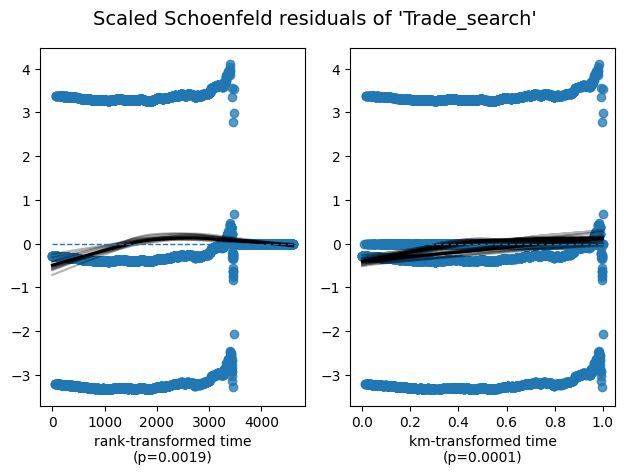

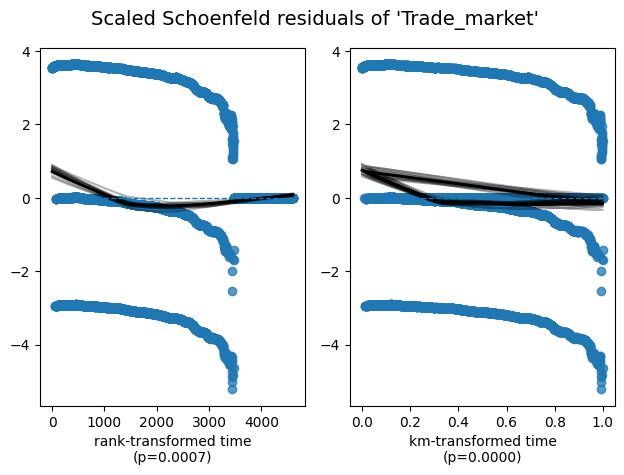

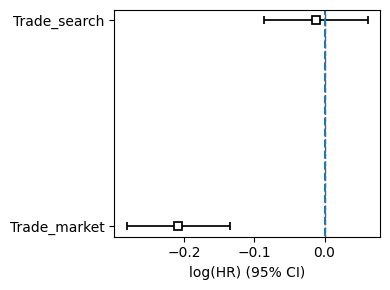

In [4]:
cox_analysis = True

if cox_analysis:
    combined_df = pd.concat([cphs[f'Baseline-no_trade-Uniform-300-0.8'],
                             cphs[f'Baseline-random-Uniform-300-0.8'],
                             cphs[f'Baseline-pathfind_neighbor-Uniform-300-0.8'],
                             cphs[f'Market-pathfind_market-Uniform-300-0.8'],
    ])

    
    le = LabelEncoder()
    print(combined_df.keys())

    def update_trades(row):
        if row["Agent_type"] == 'no_trade':
            row["Trade_random"] = 0
            row["Trade_search"] = 0
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'random':
            row["Trade_random"] = 1
            row["Trade_search"] = 0
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'pathfind_neighbor':
            row["Trade_random"] = 0
            row["Trade_search"] = 1
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'pathfind_market':
            row["Trade_random"] = 0
            row["Trade_search"] = 0
            row["Trade_market"] = 1
        return row

    # Assuming you have a DataFrame named combined_df
    combined_df = combined_df.apply(update_trades, axis=1)
    
    combined_df["Scenario"] = le.fit_transform(combined_df["Scenario"])
    combined_df["Trading"] = le.fit_transform(combined_df["Trading"])
    combined_df["Distribution"] = le.fit_transform(combined_df["Distribution"])
    combined_df = combined_df.drop(["Run_number", 'Num_agents', 'Distribution', 'Move_prob', 'Trading', 'Agent_type', 'Scenario'], axis=1)

    print( combined_df)
    combined_df.to_csv(f"outputs/{date_time_str}_CPH-trading-Sides-data.csv")

    cph = CoxPHFitter(penalizer=0.1)
    cph.fit(combined_df, "T", "E", show_progress=False)
    cph.check_assumptions(combined_df.reset_index(drop=True), p_value_threshold=0.05, show_plots=True)


    cph.print_summary()
    cph_df = cph.summary
    cph_df.to_csv(f"outputs/{date_time_str}_CPH-trading-Sides-results.csv")

    plt.figure(figsize=(4, 3))
    cph.plot()
    plt.vlines(x=0, ymin=-1, ymax=6, color='#1f77b4', linestyles='--')
    plt.tight_layout()
    plt.show()

# CPH for all data

In [17]:
cox_analysis = True

if cox_analysis:
    # Analysis
    def concatAllRuns(data_path: Path):
        csv_files = glob.glob(os.path.join(data_path, f"outputs/{date_time_str}/*.csv"))
        combined_df = pd.concat([pd.read_csv(f) for f in csv_files])
        return combined_df
    
    date_time_str = '20230622_002127'
    data_path = Path(os.getcwd())
    combined_df = concatAllRuns(data_path)
    print(combined_df)
    
    le = LabelEncoder()
    print(combined_df.keys())

    def update_trades(row):
        if row["Agent_type"] == 'no_trade':
            row["Trade_random"] = 0
            row["Trade_search"] = 0
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'random':
            row["Trade_random"] = 1
            row["Trade_search"] = 0
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'pathfind_neighbor':
            row["Trade_random"] = 0
            row["Trade_search"] = 1
            row["Trade_market"] = 0
        elif row["Agent_type"] == 'pathfind_market':
            row["Trade_random"] = 0
            row["Trade_search"] = 0
            row["Trade_market"] = 1
        return row

    # Assuming you have a DataFrame named combined_df
    combined_df = combined_df.apply(update_trades, axis=1)
    
    combined_df["Scenario"] = le.fit_transform(combined_df["Scenario"])
    combined_df["Trading"] = le.fit_transform(combined_df["Trading"])
    combined_df["Distribution"] = le.fit_transform(combined_df["Distribution"])
    combined_df = combined_df.drop(["Run_number", 'Trading', 'Agent_type', 'Scenario'], axis=1)

    print( combined_df.tail())
    combined_df.to_csv(f"outputs/{date_time_str}_CPH-trading-RG-50-0.8-data.csv")

    cph = CoxPHFitter(penalizer=0.1)
    cph.fit(combined_df, "T", "E", show_progress=False)
    cph.check_assumptions(combined_df.reset_index(drop=True), p_value_threshold=0.05, show_plots=True)

    cph.print_summary()
    print("Summary dataframe:")
    cph_df = cph.summary
    print(cph_df)
    cph_df.to_csv(f"outputs/{date_time_str}_CPH-trading-results-all.csv")

        T    E  Scenario       Agent_type Distribution  Num_agents  Trading  \
0   538.0  1.0  Baseline         no_trade   RandomGrid         100    False   
1   327.0  1.0  Baseline         no_trade   RandomGrid         100    False   
2     0.0  0.0  Baseline         no_trade   RandomGrid         100    False   
3   643.0  1.0  Baseline         no_trade   RandomGrid         100    False   
4   121.0  1.0  Baseline         no_trade   RandomGrid         100    False   
..    ...  ...       ...              ...          ...         ...      ...   
45    0.0  0.0    Market  pathfind_market      Uniform          50     True   
46    0.0  0.0    Market  pathfind_market      Uniform          50     True   
47    0.0  0.0    Market  pathfind_market      Uniform          50     True   
48    0.0  0.0    Market  pathfind_market      Uniform          50     True   
49    0.0  0.0    Market  pathfind_market      Uniform          50     True   

    Move_prob  Run_number  
0         0.5          

<lifelines.CoxPHFitter: fitted with 117000 total observations, 24023 right-censored observations>
             duration col = 'T'
                event col = 'E'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 117000
number of events observed = 92977
   partial log-likelihood = -969379.66
         time fit was run = 2023-06-22 00:13:48 UTC

---
               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                            
Distribution  -0.12       0.89       0.00            -0.12            -0.11                 0.88                 0.90
Num_agents     0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
Move_prob     -0.16       0.85       0.01            -0.19            -0.13                 0.82                 0.87
Trade_random  -0.15       0.86       0.01            -0.17            -0.13                 0.85                 0.88
Trade_search  -0.28       0.76       0.01            -0.29            -0.26                 0.75                 0.77
Trade_market  -0.18       0.84       0.01            -0.20            -0.16                 0.82                 0.85

               cmp to      z      p   -log2(p)
covariate                                     
Distribution     0.00 -33.83 <0.005     830.92
Num_agents       0.00  25.05 <0.005     457.45
Move_prob        0.00 -10.90 <0.005      89.52
Trade_random     0.00 -17.74 <0.005     231.56
Trade_search     0.00 -32.96 <0.005     788.88
Trade_market     0.00 -21.86 <0.005     349.43
---
Concordance = 0.50
Partial AIC = 1938771.32
log-likelihood ratio test = 2656.57 on 6 df
-log2(p) of ll-ratio test = inf

Summary dataframe:
                  coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                     
Distribution -0.117663   0.888995  0.003478       -0.124480       -0.110846   
Num_agents    0.001058   1.001059  0.000042        0.000975        0.001141   
Move_prob    -0.163526   0.849145  0.014999       -0.192924       -0.134127   
Trade_random -0.148898   0.861657  0.008392       -0.165346       -0.132449   
Trade_search -0.275453   0.759228  0.008358       -0.291834       -0.259072   
Trade_market -0.179182   0.835953  0.008197       -0.195249       -0.163116   

              exp(coef) lower 95%  exp(coef) upper 95%  cmp to          z  \
covariate                                                                   
Distribution             0.882956             0.895076     0.0 -33.829114   
Num_agents               1.000976             1.001141     0.0  25.045211   
Move_prob                0.824545       

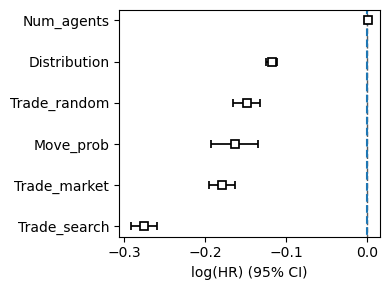

In [18]:
plt.figure(figsize=(4, 3))
cph.plot()
plt.vlines(x=0, ymin=-1, ymax=6, color='#1f77b4', linestyles='--')
plt.tight_layout()
plt.show()